<a href="https://colab.research.google.com/github/ahadAli102/covid-sentiment-analysis/blob/main/gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
# dataset path
path = '/content/drive/My Drive/Colab Notebooks/NLP Projects/sentiment/'

Total number of headlines: 1110


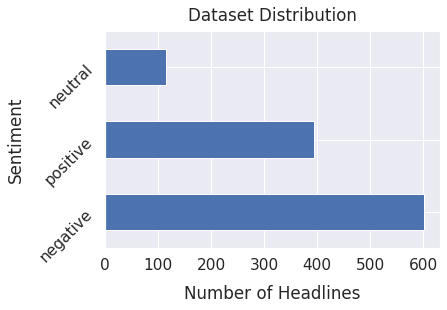

In [ ]:
data = pd.read_csv('/content/data-collect - Copy.csv',encoding='utf-8')
data = data.drop(range(0,100))
print(f'Total number of headlines: {len(data)}')
sns.set(font_scale=1.4)
data['sentiment'].value_counts().plot(kind='barh', figsize=(6, 4))
plt.xlabel("Number of Headlines", labelpad=12)
plt.ylabel("Sentiment", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [ ]:
data.columns

Index(['comments', 'sentiment'], dtype='object')

In [ ]:
# Cleaning Data [Remove unncessary symbols]
def cleaning_data(row):
      comment = re.sub('[^\u0980-\u09FF]',' ',str(row)) #removing unnecessary punctuation
      return comment
# Apply the function into the dataframe
data['cleaned'] = data['comments'].apply(cleaning_data)  

# print some cleaned reviews from the dataset
sample_data = [250,350]
for i in sample_data:
  print('Original: ',data.comments[i],'\nCleaned:',
           data.cleaned[i],'\n','Category:-- ',data.sentiment[i],'\n')  

Original:  ভারত টিকা ১টানা ১০ বছর সুরক্ষা দেয়, তাই সবাই ভারতের টিকা দিন 
Cleaned: ভারত টিকা ১টানা ১০ বছর সুরক্ষা দেয়  তাই সবাই ভারতের টিকা দিন 
 Category:--  positive 

Original:  টিকা নিতে মন চায়না 
Cleaned: টিকা নিতে মন চায়না 
 Category:--  negative 



In [ ]:
data.drop(['sentiment'], axis=1)

,comments,cleaned
100,আমার পরিবারের সবাই নিবন্ধনের ২ মাসের মধ্যেই টি...,আমার পরিবারের সবাই নিবন্ধনের ২ মাসের মধ্যেই টি...
101,সরকার বিনামূল্যে টিকা দিচ্ছে অথচ এসব উজবুকরা এ...,সরকার বিনামূল্যে টিকা দিচ্ছে অথচ এসব উজবুকরা এ...
102,১ম ডোজ দিয়েছেন আজ প্রায় ৪ মাস হলো। ২য় ডোজ দেয়া...,১ম ডোজ দিয়েছেন আজ প্রায় ৪ মাস হলো ২য় ডোজ দেয়া...
103,ষাটোর্ধ্বদের মৃত্যুঝুঁকি বেশি। তাঁদের বিরাট অং...,ষাটোর্ধ্বদের মৃত্যুঝুঁকি বেশি তাঁদের বিরাট অং...
104,এই টিকা নিলে এই হবে সেই হবে... পেট ব্যথায় মরে ...,এই টিকা নিলে এই হবে সেই হবে পেট ব্যথায় মরে ...
...,...,...
1205,এদিকে টিকে নেওয়ায় শিশুর মৃত্যুর নিউজ পেলাম!,এদিকে টিকে নেওয়ায় শিশুর মৃত্যুর নিউজ পেলাম
1206,আমি ১ম ডোজ নিয়েছি।আলহামদুলিল্লাহ সুস্থ আছি।,আমি ১ম ডোজ নিয়েছি আলহামদুলিল্লাহ সুস্থ আছি
1207,টীকা নেওয়ার পরে আমার শরীরে ব্যথা দেখা দিয়েছে।,টীকা নেওয়ার পরে আমার শরীরে ব্যথা দেখা দিয়েছে
1208,কোনো পার্শ্ব প্রতিক্রিয়াই দেখলাম না প্রথম ডোজ ...,কোনো পার্শ্ব প্রতিক্রিয়াই দেখলাম না প্রথম ডোজ ...


In [ ]:
def data_summary(dataset):
    
    """
    This function will print the summary of the headlines and words distribution in the dataset. 
    
    Args:
        dataset: list of cleaned sentences   
        
    Returns:
        Number of documnets per class: int 
        Number of words per class: int
        Number of unique words per class: int
    """
    documents = []
    words = []
    u_words = []
    total_u_words = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.sentiment.value_counts().to_dict().items()]
  # find word list
    for label in class_label: 
        word_list = [word.strip().lower() for t in list(dataset[dataset.sentiment==label].cleaned) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
        # sort the dictionary of word list  
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        # Documents per class
        documents.append(len(list(dataset[dataset.sentiment==label].cleaned)))
        # Total Word per class
        words.append(len(word_list))
        # Unique words per class 
        u_words.append(len(np.unique(word_list)))
       
        print("\nClass Name : ",label)
        print("Number of Documents:{}".format(len(list(dataset[dataset.sentiment==label].cleaned))))  
        print("Number of Words:{}".format(len(word_list))) 
        print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))           
   
    return documents,words,u_words,class_label

#call the fucntion
documents,words,u_words,class_names = data_summary(data)   


Class Name :  negative
Number of Documents:601
Number of Words:5843
Number of Unique Words:1728
Most Frequent Words:

টিকা	530
না	150
করোনা	114
নেওয়ার	74
টিকার	68
পর	65
আক্রান্ত	61
এই	56
আমি	44
মারা	42

Class Name :  positive
Number of Documents:394
Number of Words:4189
Number of Unique Words:1390
Most Frequent Words:

টিকা	363
করোনা	73
হবে	61
না	45
আমি	39
টিকার	37
এই	34
কোন	31
নিলে	29
আমার	28

Class Name :  neutral
Number of Documents:115
Number of Words:1272
Number of Unique Words:683
Most Frequent Words:

টিকা	97
না	30
করোনা	23
কি	16
টিকার	14
আর	11
করে	10
নিয়ে	9
নাকি	9
তা	9
Total Number of Unique Words:2798


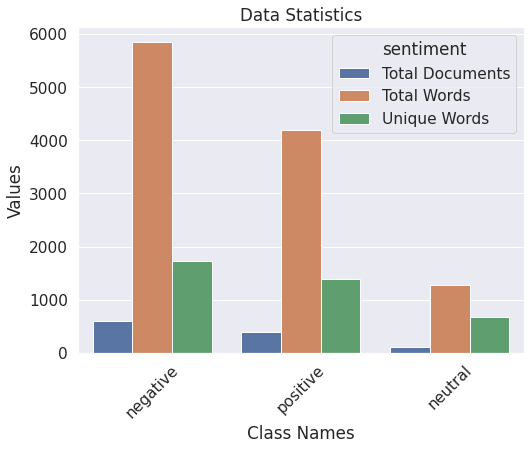

In [ ]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="sentiment", value_name="Values")
plt.figure(figsize=(8, 6))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='sentiment')
ax.set_xlabel('Class Names') 
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

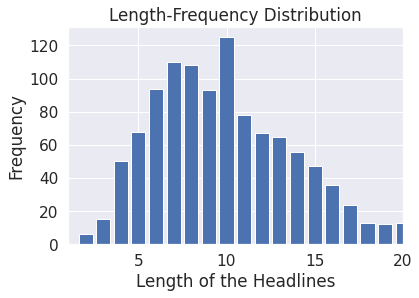

Maximum Length of a headline: 34
Minimum Length of a headline: 2
Average Length of a headline: 10.0


In [ ]:
# Calculate the Review of each of the Review
data['comments_length'] = data.cleaned.apply(lambda x:len(x.split()))
frequency = dict()
for i in data.comments_length:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 20)
# in this notbook color is not working but it should work.
plt.xlabel('Length of the Headlines')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  
print(f"Maximum Length of a headline: {max(data.comments_length)}")
print(f"Minimum Length of a headline: {min(data.comments_length)}")
print(f"Average Length of a headline: {round(np.mean(data.comments_length),0)}")

In [ ]:
def label_encoding(sentiment,bool):
    """
    This function will return the encoded labels in array format. 
    
    Args:
        sentiment: series of class names(str)
        bool: boolean (True or False)
        
    Returns:
        labels: numpy array 
    """
    le = LabelEncoder()
    le.fit(sentiment)
    encoded_labels = le.transform(sentiment)
    labels = np.array(encoded_labels) # Converting into numpy array
    class_names =le.classes_ ## Define the class names again
    if bool == True:
        print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->",le.classes_)
        for i in sample_data:
            print(sentiment[i],' ', encoded_labels[i],'\n')

    return labels

In [ ]:
def dataset_split(headlines,category):
    """
    This function will return the splitted (90%-10%-10%) feature vector . 
    
    Args:
        headlines: sequenced headlines 
        category: encoded lables (array) 
        
    Returns:
        X_train: training data 
        X_valid: validation data
        X_test : testing feature vector 
        y_train: training encoded labels (array) 
        y_valid: training encoded labels (array) 
        y_test : testing encoded labels (array) 
    """
    X,X_test,y,y_test = train_test_split(headlines,category,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
    print(color.BOLD+"\nDataset Distribution:\n"+color.END)
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",len(headlines),
        "\n\tTraining\t\t",len(X_train),
        "\n\tTest\t\t\t",len(X_test),
        "\n\tValidation\t\t",len(X_valid))
  
    return X_train,X_valid,X_test,y_train,y_valid,y_test


In [ ]:
labels = label_encoding(data.sentiment,True)


			===== Label Encoding ===== 
Class Names:--> ['negative' 'neutral' 'positive']
positive   0 

negative   0 



In [ ]:
X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(data.comments,labels)


Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 1110 
	Training		 799 
	Test			 111 
	Validation		 200


In [ ]:
vocab_size = 57000
embedding_dim = 64
max_length = 21
trunc_type='post'
padding_type='post'
oov_tok = ""

def padded_comment(original,encoded,padded):
  '''
  print the samples padded comment
  '''
  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\n")  
  print(original,"\n",encoded) 
  print(color.BOLD+"\n\t\t\t====== Paded Sequences ======\n"+color.END,original,"\n",padded)  

In [ ]:
# Train Data Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

In [ ]:
 #============================== Tokenizer Info =================================
(word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
def tokenizer_info(mylist,bool):
  ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = bool)
  for w,c in ordered[:10]:
    print(w,"\t",c)
  #=============================== Print all the information =========================
print(color.BOLD+"\t\t\t====== Tokenizer Info ======"+color.END)   
print("Words --> Counts:")
tokenizer_info(word_counts,bool =True )
print("\nWords --> Documents:")
tokenizer_info(word_docs,bool =True )
print("\nWords --> Index:")
tokenizer_info(word_index,bool =True )    
print("\nTotal Documents -->",document_count)
print(f"Found {len(word_index)} unique tokens")

			====== Tokenizer Info ======
Words --> Counts:
টিকা 	 694
করোনা 	 144
না 	 135
টিকার 	 81
পর 	 74
নেওয়ার 	 69
এই 	 68
আমি 	 65
হবে 	 61
আক্রান্ত 	 56

Words --> Documents:
টিকা 	 588
করোনা 	 140
না 	 120
টিকার 	 79
পর 	 73
নেওয়ার 	 65
এই 	 64
আমি 	 60
আক্রান্ত 	 54
হবে 	 53

Words --> Index:
এসেই 	 2400
দিব 	 2399
দিয়েই 	 2398
আমিতো 	 2397
জনসন 	 2396
আমেরিকার 	 2395
রাশিয়ার 	 2394
উঠিয়ে 	 2393
উছিলায় 	 2392
হয়ত 	 2391

Total Documents --> 799
Found 2400 unique tokens


In [ ]:
X_train

436     ছয় মাস পরে নাকি টিকার কার্যকারিতা কমে যায় তা...
988     মানুষের হায়াত /রিযিক যতদিন আছে ততদিন ই বাঁচে। ...
194     টিকা আসলে সেটার ব্যবস্থাপনাও ত্রাণের মত হয়ে যাবে।
607     প্রথম ডোজ ফাইজার আর দ্বিতীয় ডোজ এস্ট্রাজেনিকা/...
104     এই টিকা নিলে এই হবে সেই হবে... পেট ব্যথায় মরে ...
                              ...                        
1025                            আমিতো ভ্যাক্সিন নিবো ই না
1175                      করোনা ভ্যাকসিন ওইটা দিয়েই দিব!!
966                               টিকার উপর কোনো ভরসা নেই
1083                                  টিকা না নিলে সমস্যা
1128             টিকে নিতে এসেই করোনার সংক্রমণ নিয়ে যাবে!
Name: comments, Length: 799, dtype: object

In [ ]:
# for /content/Sentimentdata - Copy.csv
index = 684
#padded_comment(X_train[index],train_sequences[index],train_padded[index]) 

In [ ]:
X_valid

904     টিকা নিলে যে করোনা হবে না তাতো না।টিকা তো করোন...
1039                               আম জনতার টিকা লাগবে না
375              টিকা নামে শরীরে জোর করে কী ঢুকিয়ে দিচ্ছে
736            করোনা টিকার মূল চাবিকাঠি কাঁকড়ার নীল রক্ত
223     জনগণকে টিকা দিতে হলে সেনাবাহিনী নামিয়ে দিতে বল...
                              ...                        
710     অল্প টিকা এগুলো প্রথমে সিনিয়র রাজনৈতিক নেতাদের...
765     আমার ছেলেকে করোনা টিকা দেয়ালাম আমার অফিসের কয়ে...
147     চিনা টিকার কার্যকারিতা কম।শেষে\nদেশে দেখা যাবে...
172     টিকা আনবে beximco সেই টিকা ১০০ গুন বেশি দাম দি...
209              কারখানা হই অথবা গোডাউন তবুও টিকা নিব না।
Name: comments, Length: 200, dtype: object

In [ ]:
# Validation Data Tokenization for /content/Sentimentdata - Copy.csv
index = 172
validation_sequences = tokenizer.texts_to_sequences(X_valid)
validation_padded = pad_sequences(validation_sequences, padding=padding_type , maxlen=max_length)
#padded_comment(X_valid[index],validation_sequences[index],validation_padded[index]) 

In [ ]:
X_test

713     প্রধানমন্ত্রী সহ সকল মন্ত্রীদের প্রকাশ্যে টিকা...
1084                        টিকা নিয়েও বা কি বাল হচ্ছে? 
1195                         সিনোফার্মেরটাই বেশি কার্যকর।
594     টিকার সাইডএফেক্টে অনেকে মারা যাচ্ছে, ফ্রান্স, ...
841     আগে করোনার সকল ধরনের বেরিয়ে নিক , তারপর আমি ফ...
                              ...                        
543                 সারা পৃথিবী ভাপছে এই টিকার সফলতা নিয়ে
786     এই করোনা টিকা সম্পূর্ণ নিরাপদ।যদি কারো মৃত্যু ...
525     টিকা নিয়ে নিজে সুস্থ থাকি বাকি সব কিছু আল্লাহর...
932     স্যালাইনের পানি টিকা হিসাবে ব্যবহার করলে এমন হবেই
368     প্রতিটি টীকা সফল হউক।।বৈশ্বিক এই মহামারীতে তড়ি...
Name: comments, Length: 111, dtype: object

In [ ]:
# Test Data Tokenization
index = 70
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type , maxlen=max_length)
#padded_comment(X_test[index],test_sequences[index],test_padded[index]) 

In [ ]:
train_label_seq = y_train
valid_label_seq = y_valid
testing_label_seq = y_test

In [ ]:
keras.backend.clear_session()
accuracy_threshold = 1.0
vocab_size = 57000
embedding_dim = 64
max_length = 21
num_category = 6

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = path+"Model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
callback_list = [acc_callback, checkpoint] 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(GRU(64,dropout=0.2)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_category, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 64)            3648000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49920     
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 flatten (Flatten)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 150       
                                                                 
Total params: 3,701,166
Trainable params: 3,701,166
Non-trainable params: 0
______________________________________________

In [ ]:
num_epochs = 10
batch = 64
history = model.fit(train_padded, train_label_seq, 
                    epochs=num_epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, valid_label_seq), 
                    verbose=1,
                    callbacks = callback_list)

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 1.7213 - accuracy: 0.5332
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/My Drive/Colab Notebooks/NLP Projects/sentiment/Model.h5
13/13 [==============================] - 11s 148ms/step - loss: 1.7213 - accuracy: 0.5332 - val_loss: 1.6145 - val_accuracy: 0.5000
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 1.4237 - accuracy: 0.5544
Epoch 2: val_accuracy did not improve from 0.50000
13/13 [==============================] - 1s 68ms/step - loss: 1.4237 - accuracy: 0.5544 - val_loss: 1.2768 - val_accuracy: 0.5000
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 1.0905 - accuracy: 0.4869
Epoch 3: val_accuracy improved from 0.50000 to 0.50500, saving model to /content/drive/My Drive/Colab Notebooks/NLP Projects/sentiment/Model.h5
13/13 [==============================] - 1s 78ms/step - loss: 1.0905 - accuracy: 0.4869 - val_loss: 1.0460 - val_accurac

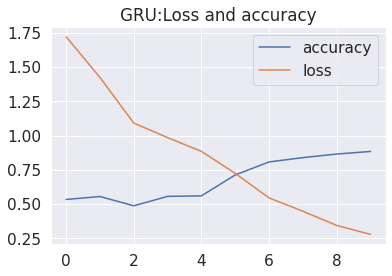

In [ ]:
plt.title('GRU:Loss and accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['accuracy', 'loss'])
plt.show()

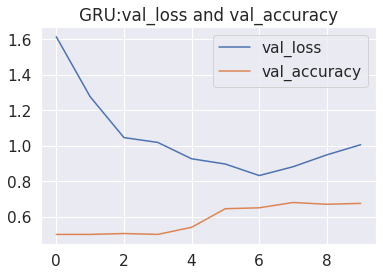

In [ ]:
plt.title('GRU:val_loss and val_accuracy')
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.legend(['val_loss', 'val_accuracy'])
plt.show()

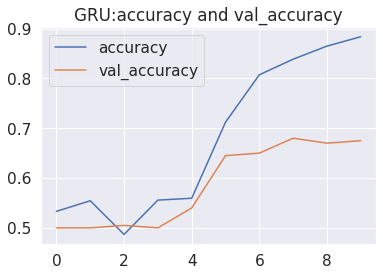

In [ ]:
plt.title('GRU:accuracy and val_accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

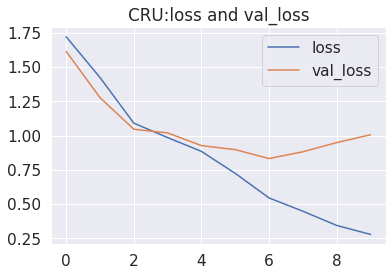

In [ ]:
plt.title('CRU:loss and val_loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# load the Saved model from directory
# model = load_model(path+"Model.h5")
# predictions = model.predict(test_padded)
# y_pred = np.argmax(predictions, axis=1)

# cm = confusion_matrix(testing_label_seq, y_pred) 

# # Transform to df for easier plotting
# cm_df = pd.DataFrame(cm,
                     
#                      index = ['negative' , 'neutral' , 'positive'], 
#                      columns = ['negative' , 'neutral' , 'positive'])

# plt.figure(figsize=(8,6))
# sns.heatmap(cm_df, annot=True,cmap="YlGnBu", fmt='g')
# plt.title('GRU \nAccuracy: {0:.2f}'.format(accuracy_score(testing_label_seq, y_pred)*100))
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.xticks(rotation = 45)
# plt.yticks(rotation = 45)
# plt.show()

In [ ]:
print('GRU')
print('Accuracy: {0:.2f}'.format(np.max(history.history['accuracy'])*100))
print('loss: {0:.2f}'.format(np.min(history.history['loss'])))
print('val_accuracy: {0:.2f}'.format(np.max(history.history['val_accuracy'])*100))
print('val_loss: {0:.2f}'.format(np.min(history.history['val_loss'])))

GRU
Accuracy: 88.36
loss: 0.28
val_accuracy: 68.00
val_loss: 0.83


In [ ]:
for i in history.history['accuracy']:
  print(f'{i:.4f} ')

0.5332 
0.5544 
0.4869 
0.5557 
0.5594 
0.7121 
0.8073 
0.8385 
0.8648 
0.8836 


In [ ]:
for i in history.history['loss']:
  print(f'{i:.4f} ')

1.7213 
1.4237 
1.0905 
0.9849 
0.8842 
0.7234 
0.5442 
0.4470 
0.3435 
0.2778 


In [ ]:
for i in history.history['val_accuracy']:
  print(f'{i:.4f} ')

0.5000 
0.5000 
0.5050 
0.5000 
0.5400 
0.6450 
0.6500 
0.6800 
0.6700 
0.6750 


In [ ]:
for i in history.history['val_loss']:
  print(f'{i:.4f} ')

1.6145 
1.2768 
1.0460 
1.0187 
0.9265 
0.8968 
0.8319 
0.8815 
0.9485 
1.0058 
